In [2]:
import pandas as pd
import numpy as np
import re
import torch
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments)
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [3]:
# Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_json(next(iter(uploaded))).T  # Load JSON file

Saving sarcasm_data.json to sarcasm_data.json


In [4]:
# --- TEXT PREPROCESSING ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['utterance'] = df['utterance'].apply(clean_text)
df['context'] = df['context'].apply(lambda x: [clean_text(c) for c in x])

df = df[['utterance', 'context', 'sarcasm']]


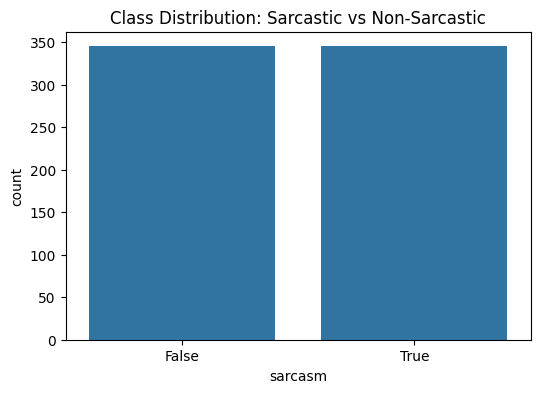

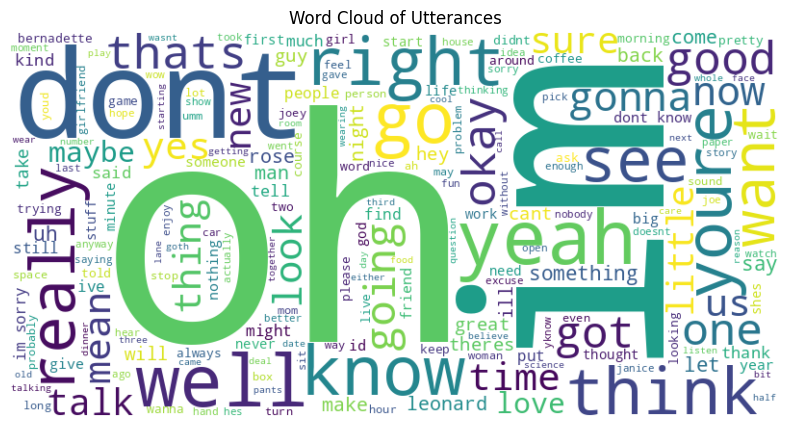

In [5]:
# --- VISUALIZATION ---
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['sarcasm'])
plt.title("Class Distribution: Sarcastic vs Non-Sarcastic")
plt.show()

# Word Cloud
all_text = " ".join(df['utterance'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Utterances")
plt.show()


In [6]:
# --- FEATURE EXTRACTION ---

# Sentiment Analysis
def get_sentiment(text):
    sentiment_score = TextBlob(text).sentiment.polarity  # Ranges from -1 to 1
    sentiment_label = 1 if sentiment_score > 0 else 0  # 1 = Positive, 0 = Negative
    return sentiment_score, sentiment_label

df[['sentiment_score', 'sentiment_label']] = df['utterance'].apply(lambda x: pd.Series(get_sentiment(x)))

# Linguistic Features
def extract_features(text):
    word_count = len(text.split())
    uppercase_count = sum(1 for word in text.split() if word.isupper())
    avg_word_length = sum(len(word) for word in text.split()) / word_count if word_count else 0
    lexical_diversity = len(set(text.split())) / word_count if word_count else 0
    return word_count, uppercase_count, avg_word_length, lexical_diversity

df[['word_count', 'uppercase_count', 'avg_word_length', 'lexical_diversity']] = df['utterance'].apply(lambda x: pd.Series(extract_features(x)))

# Punctuation Features
def count_punctuation_types(text):
    exclamation_count = text.count("!")
    question_count = text.count("?")
    mixed_count = text.count("!?") + text.count("?!")
    return exclamation_count, question_count, mixed_count

df[['exclamation_count', 'question_count', 'mixed_punctuation_count']] = df['utterance'].apply(lambda x: pd.Series(count_punctuation_types(x)))


In [7]:
# --- TOKENIZATION & CONTEXT EMBEDDING ---
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Ensure context is correctly converted to a list of strings
context_encodings = tokenizer(list(df['context'].apply(lambda x: " ".join(x))),
                              truncation=True, padding=True, max_length=128, return_tensors="pt")

utterance_encodings = tokenizer(list(df['utterance']),
                                truncation=True, padding=True, max_length=128, return_tensors="pt")

# Generate Context Embeddings
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

with torch.no_grad():
    context_outputs = model.roberta(context_encodings["input_ids"],
                                    attention_mask=context_encodings["attention_mask"])
    context_embeddings = context_outputs.last_hidden_state.mean(dim=1)  # Compute mean embedding


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# --- TRAINING AND EVALUATION METRICS ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(labels, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "eval_accuracy": float(acc),
        "eval_precision": float(precision),
        "eval_recall": float(recall),
        "eval_f1": float(f1)
    }


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivam-wangikar (shivam-wangikar-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702700,0.678768,0.615942,0.615942,1.000000,0.762332
2,0.691600,0.691434,0.586957,0.632075,0.788235,0.701571
3,0.676700,0.683973,0.623188,0.673684,0.752941,0.711111


Confusion Matrix:
 [[ 0 53]
 [ 0 85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.62      1.00      0.76        85

    accuracy                           0.62       138
   macro avg       0.31      0.50      0.38       138
weighted avg       0.38      0.62      0.47       138



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


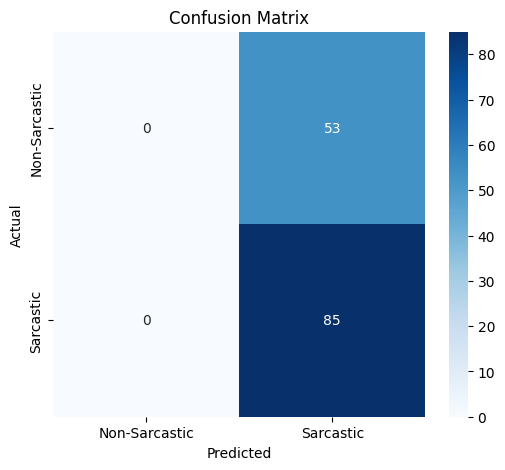

Confusion Matrix:
 [[14 39]
 [18 67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.26      0.33        53
           1       0.63      0.79      0.70        85

    accuracy                           0.59       138
   macro avg       0.53      0.53      0.52       138
weighted avg       0.56      0.59      0.56       138



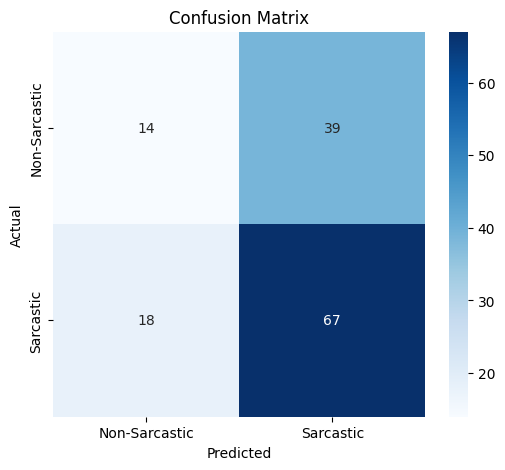

Confusion Matrix:
 [[22 31]
 [21 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.42      0.46        53
           1       0.67      0.75      0.71        85

    accuracy                           0.62       138
   macro avg       0.59      0.58      0.58       138
weighted avg       0.61      0.62      0.61       138



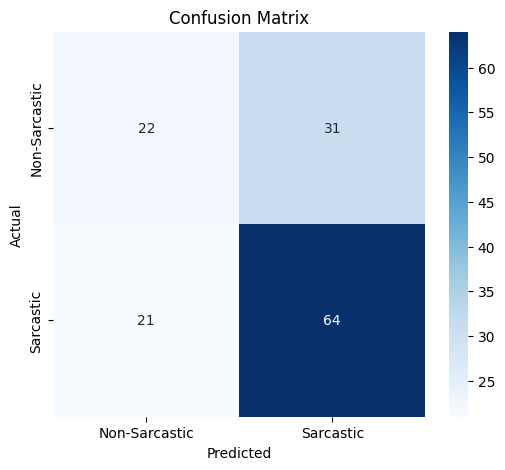

Confusion Matrix:
 [[22 31]
 [21 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.42      0.46        53
           1       0.67      0.75      0.71        85

    accuracy                           0.62       138
   macro avg       0.59      0.58      0.58       138
weighted avg       0.61      0.62      0.61       138



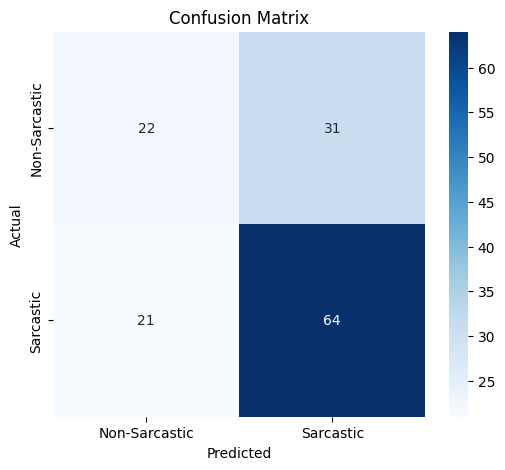

{'eval_accuracy': 0.6231884057971014, 'eval_precision': 0.6736842105263158, 'eval_recall': 0.7529411764705882, 'eval_f1': 0.7111111111111111, 'eval_loss': 0.6839725375175476, 'eval_runtime': 24.5483, 'eval_samples_per_second': 5.622, 'eval_steps_per_second': 0.122, 'epoch': 3.0}


ModuleNotFoundError: No module named 'gradio'

In [9]:
# --- FINE-TUNED TRAINING SETUP ---
# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['utterance'], df['sarcasm'], test_size=0.2, random_state=42
)

# Reset indices of train_labels and val_labels to ensure they are sequential
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Tokenize the training and validation sets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Create Torch datasets
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # Convert labels to tensors with correct shape and type
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

# Create the training and validation datasets
train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for checkpoints and logs
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,                # Log every X updates steps
    evaluation_strategy="epoch"      # Evaluate the model at the end of each epoch
)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save model
model.save_pretrained("sarcasm_roberta_final_model")
tokenizer.save_pretrained("sarcasm_roberta_final_model")

# Evaluate model
metrics = trainer.evaluate()
print(metrics)



In [10]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

In [11]:
import gradio as gr

# --- GRADIO INTERFACE ---
def test_model(text):
    inputs = tokenizer(text, return_tensors="pt")
    output = model(**inputs)
    return "Sarcastic" if output.logits.argmax() == 1 else "Non-Sarcastic"  # Corrected the output

gr.Interface(fn=test_model, inputs="text", outputs="label").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://305e95fac05dfe330f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
